<a href="https://colab.research.google.com/github/Yogesh7920/Pascal-VOC/blob/main/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Needed for BERT.
"""
!pip install tensorflow-text
!pip install tensorflow_addons

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
import tqdm.notebook as tq

# Tensorflow
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss, BinaryCrossentropy
from keras.utils import plot_model
import tensorflow_datasets as tfds
from tensorflow.image import resize, ResizeMethod 
from tensorflow.data import Dataset
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, \
                                    BatchNormalization, GlobalAveragePooling2D, Lambda, \
                                    Embedding, GlobalAveragePooling1D, Concatenate, LSTM, \
                                    Bidirectional, Input, Reshape
from tensorflow.keras.regularizers import L2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import Resizing, TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.applications import   VGG19, vgg19, VGG16, vgg16, InceptionV3, inception_v3, \
                                            Xception, xception
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Model, load_model
from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.keras.callbacks import ReduceLROnPlateau

# sklearn
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

## Downloading data from drive

In [2]:
data_path = '/content/drive/MyDrive/IIT Palakkad/Sem-6/Deep Learning/Project/cache/'
model_path = '/content/drive/MyDrive/IIT Palakkad/Sem-6/Deep Learning/Project/Models/'

In [3]:
labels = np.array(['person', 'bird', 'cat', 'cow', 'dog', 'horse',
              'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car',
              'motorbike', 'train', 'bottle', 'chair', 'dining table',
              'potted plant', 'sofa', 'tv/monitor'])

get_resized_images = True

if get_resized_images:
    abstract_images = np.load(data_path + 'abstract_images_resized.npy', allow_pickle=True)
else:
    abstract_images = np.load(data_path + 'abstract_images.npy', allow_pickle=True)
abstract_images = abstract_images[:, :, :, :3]

if get_resized_images:
    pascal_images = np.load(data_path + 'pascal_images_resized.npy', allow_pickle=True)
else:
    pascal_images = np.load(data_path + 'pascal_images.npy', allow_pickle=True)

abstract_targets = np.load(data_path + 'abstract_targets.npy', allow_pickle=True)
pascal_targets = np.load(data_path + 'pascal_targets.npy', allow_pickle=True)

abstract_annots_concat = np.load(data_path + 'abstract_annots_concat.npy', allow_pickle=True)
pascal_annots_concat = np.load(data_path + 'pascal_annots_concat.npy', allow_pickle=True)

### Reshape input data if required

In [4]:
"""Input shape for the CNN"""
input_shape=(224, 224, 3)

def resize_images(dataset):
    ls = []
    for img in tqdm(dataset):
        img = resize(img, size=input_shape[0:2], method=ResizeMethod.AREA)
        ls.append(img)
    return np.array(ls)

if not get_resized_images:
    pascal_images = resize_images(pascal_images)
    abstract_images = resize_images(abstract_images)
    np.save(data_path + 'abstract_images_resized.npy', abstract_images)
    np.save(data_path + 'pascal_images_resized.npy', pascal_images)
  
full_images = tf.convert_to_tensor(np.append(abstract_images, pascal_images, axis=0))
full_annots = tf.convert_to_tensor(np.append(abstract_annots_concat, pascal_annots_concat, axis=0), dtype=tf.string)
full_targets = tf.convert_to_tensor(np.append(abstract_targets, pascal_targets, axis=0))

del abstract_images
del pascal_images
del abstract_targets
del pascal_targets
del abstract_annots_concat
del pascal_annots_concat

## Functions necessary for model building

In [5]:
def get_text_model(vocab_size=2000, embedding_dim=128, output_sequence_length=350):
    """
    A basic model for learning text embeddings.
    """
    input = Input(shape=(), name="text_model_input", dtype='string')
    vectorize_layer = TextVectorization(
                        max_tokens=vocab_size,
                        output_mode='int',
                        output_sequence_length=output_sequence_length)(input)
    x = Embedding(vocab_size, embedding_dim)(vectorize_layer)
    x = Bidirectional(LSTM(embedding_dim))(x)
    model = Model(input, x)
    return model

def get_bert_model(trainable=False):
    """
    BERT to learn the embeddings
    """
    text_input = Input(shape=(), dtype=tf.string, name='text_model_input')
    encoder_inputs = preprocessing_layer(text_input)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    return tf.keras.Model(text_input, net)

def get_cnn_model(pre_trained, shape=(224, 224, 3), allow_train_from=None):
    pre_trained.layers[0]._name = "cnn_model_input"
    if allow_train_from is not None:
        """Fine tune the pretrained model if needed."""
        layer_names = [layer.name for layer in pre_trained.layers]
        idx = layer_names.index(allow_train_from)
        for (i, layer) in enumerate(pre_trained.layers[:idx]):
            pre_trained.layers[i].trainable = False
    else:
        pre_trained.trainable = False
    return Model(inputs=pre_trained.input, outputs=pre_trained.output)

def tokenize(texts, num_words=2000, maxlen=300):
    """Tokenizer"""
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    abstract = pad_sequences(sequences, maxlen=maxlen)
    return abstract

@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """
    Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Arguments
    ---------
    y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
    y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
    thresh: probability value above which we predict positive
        
    Returns
    -------
    macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

@tf.function
def macro_soft_f1(y, y_hat):
    """
    Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Arguments
    ---------
    y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
    y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns
    -------
    cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1
    macro_cost = tf.reduce_mean(cost)
    return macro_cost

## Load pretrained models

### Inception V3

In [6]:
"""The model"""
pre_trained = InceptionV3(include_top = False, input_shape=input_shape, weights = 'imagenet', pooling='avg')
"""The preprocessing layout."""
input_preprocessor = inception_v3.preprocess_input

### BERT from Tensorflow Hub

In [ ]:
if 'preprocessing_layer' in globals():
        del preprocessing_layer
if 'encoder' in globals():
        del encoder

def load_bert_model(trainable):
    """Load the BERT model from tensorflow hub."""
    tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
    tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
    global preprocessing_layer
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    global encoder
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=trainable, name='BERT_encoder')

load_bert_model(trainable=True)

## Preprocessing and Data Preparation

In [7]:
images_indices = list(range(full_images.shape[0]))
images = []
annotations = []
targets = []

for idx, annots in tq.tqdm(zip(images_indices, full_annots), total=len(images_indices)):
    annots_split = list(tf.strings.split(annots, sep='. ').numpy())
    n = len(annots_split)
    images.extend([idx] * n)
    annotations.extend(annots_split[:n])

images = images
annotations = tf.convert_to_tensor(annotations)

In [8]:
def preprocess_image(img):
    img = tf.expand_dims(img, axis=0)
    preprocessed = input_preprocessor(img)
    cnn_feature = pre_trained(preprocessed)
    return tf.squeeze(cnn_feature)

def preprocess_images(images):
    features = []
    for x in tq.tqdm(images, total=len(images)):
        features.append(preprocess_image(x))
    return tf.convert_to_tensor(features)

In [9]:
cnn_features = preprocess_images(full_images)

### Convert the dataset as tensorflow datasets

In [10]:
BATCH_SIZE = 32
MAX_EPOCHS = 500
DATASET_SIZE = len(images)
TRAIN_SIZE = int(0.8 * DATASET_SIZE)
TEST_SIZE = int(0.2 * DATASET_SIZE)

In [11]:
def map_func(ind, img_ind):
    return ({
        'text_model_input': annotations[ind],
        'cnn_model_input': cnn_features[img_ind],
        'original_images': full_images[img_ind]
    }, full_targets[img_ind])

temp_dataset = tf.data.Dataset.from_tensor_slices((np.array(range(len(images))), images)).shuffle(buffer_size=1000)
full_dataset = temp_dataset.map(map_func, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

### Train test split of the dataset

In [12]:
train_dataset = full_dataset.take(TRAIN_SIZE).batch(BATCH_SIZE)
test_dataset = full_dataset.skip(TRAIN_SIZE).take(TEST_SIZE).batch(BATCH_SIZE)

### Dataset distribution

In [13]:
class_weights = tf.math.reduce_sum(full_targets, axis=0)
df = pd.DataFrame(class_weights, columns=["Count"])
df.index = labels
del full_images
del full_annots
del full_targets
del images
del annotations
del cnn_features
df

,Count
person,1096
bird,107
cat,129
cow,59
dog,206
horse,60
sheep,57
aeroplane,111
bicycle,62
boat,58


### Exploring the dataset

['person']


b'Mike is jumping towards the bear'

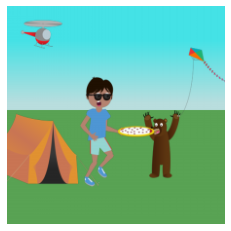

In [20]:
index = np.random.randint(250, 400)
for x, y in full_dataset.skip(index).take(1):
    image = np.clip(x['original_images']/255., 0, 1)
    idxs = y
    annots = x['text_model_input']
plt.imshow(image)
plt.axis('off')
print(labels[idxs.numpy() == 1])
annots.numpy()

## Build and train the final model

In [21]:
text_model = get_text_model(embedding_dim=256)


"""
The input layer with the features extracted from pretrained InceptionV3
"""
input = Input(shape=(2048, ), name="cnn_model_input")

"""
Concatenate image features with text features
"""
x = Concatenate()([text_model.output, input])

x = Dense(512, activation="relu", kernel_regularizer=L2(0.001))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(128, activation="relu", kernel_regularizer=L2(0.001))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
output = Dense(20, activation="sigmoid")(x)

"""
Create the model.
"""
model = Model(inputs=[text_model.input, input], outputs=output)

In [22]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_model_input (InputLayer)   [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 350)          0           text_model_input[0][0]           
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 350, 256)     512000      text_vectorization_1[0][0]       
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 512)          1050624     embedding_1[0][0]                
____________________________________________________________________________________________

In [23]:
model.compile(optimizer=Adam(learning_rate=0.01), loss=macro_soft_f1, metrics=[macro_f1])

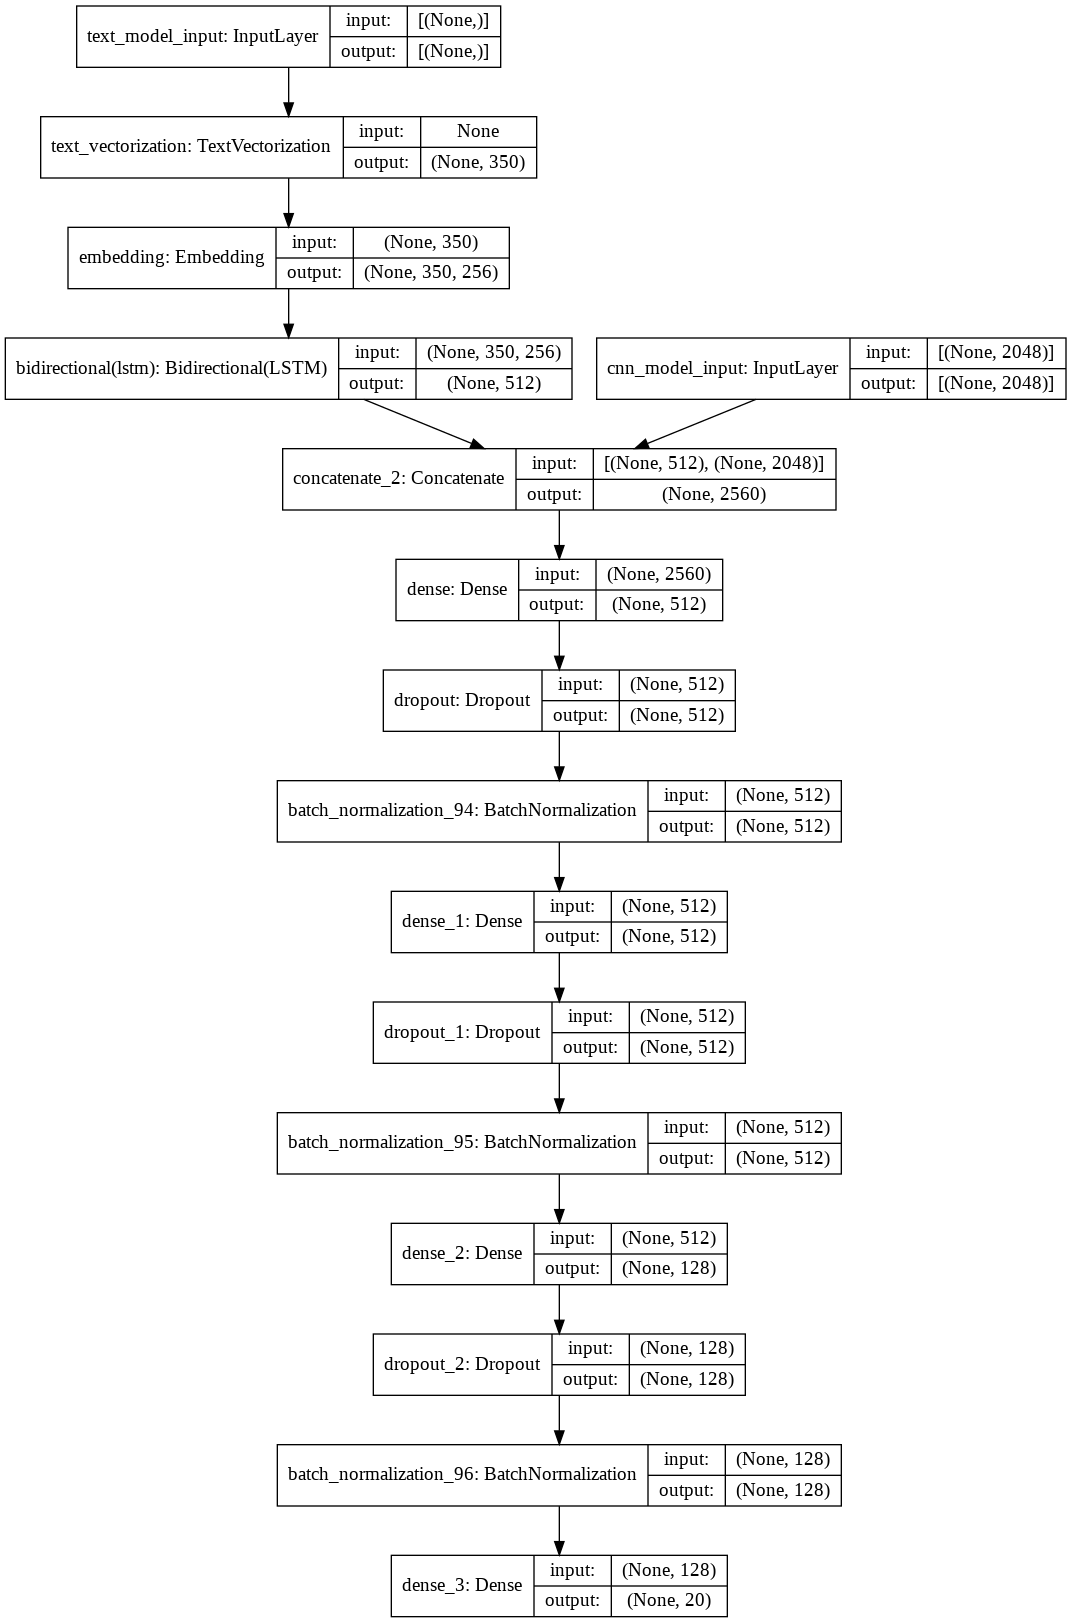

In [19]:
plot_model(model, to_file='{}task2.png'.format(model_path), show_shapes=True)

In [25]:
class ModelSaver(tf.keras.callbacks.Callback):

  def __init__(self, save_path):
    super(ModelSaver, self).__init__()
    self.save_path = save_path
    self.best_model = None
    self.best = np.Inf

  def on_epoch_end(self, epoch, logs):
    gc.collect()
    val_loss = logs.get("val_loss")
    if np.less(val_loss, self.best):
      self.best = val_loss
      self.best_model = self.model

    
  def on_train_end(self, logs=None):
    if self.best_model is not None and self.save_path is not None:
      print("Saving the best model.")   
      self.best_model.save(self.save_path, save_format='tf')
      print("Best model saved to {}".format(self.save_path))

es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=True)
cp = ModelSaver('{}model2'.format(model_path))
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

history = model.fit(train_dataset, validation_data=test_dataset, epochs=50, callbacks=[es, cp, reduce_lr], class_weight=dict(zip(range(len(labels)), class_weights.numpy())))

Epoch 1/50
188/188 [==============================] - 17s 93ms/step - loss: 575.7554 - macro_f1: 0.3862 - val_loss: 14.2827 - val_macro_f1: 0.5055
Epoch 2/50
188/188 [==============================] - 17s 92ms/step - loss: 543.9774 - macro_f1: 0.4281 - val_loss: 13.7241 - val_macro_f1: 0.5600
Epoch 3/50
188/188 [==============================] - 17s 92ms/step - loss: 533.1660 - macro_f1: 0.4339 - val_loss: 13.3231 - val_macro_f1: 0.5695
Epoch 4/50
188/188 [==============================] - 17s 92ms/step - loss: 521.9234 - macro_f1: 0.4509 - val_loss: 12.9436 - val_macro_f1: 0.5861
Epoch 5/50
188/188 [==============================] - 18s 94ms/step - loss: 510.1174 - macro_f1: 0.4647 - val_loss: 12.6703 - val_macro_f1: 0.5560
Epoch 6/50
188/188 [==============================] - 18s 93ms/step - loss: 503.9268 - macro_f1: 0.4715 - val_loss: 12.3598 - val_macro_f1: 0.5924
Epoch 7/50
188/188 [==============================] - 17s 92ms/step - loss: 495.3756 - macro_f1: 0.4790 - val_loss: 12

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIT Palakkad/Sem-6/Deep Learning/Project/Models/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIT Palakkad/Sem-6/Deep Learning/Project/Models/model2/assets


Best model saved to /content/drive/MyDrive/IIT Palakkad/Sem-6/Deep Learning/Project/Models/model2


<b>Note:</b>  
The reason for validation accuracy to be higher might be due to dropout.  
Training loss is also very high when compared to the validation loss because of the class_weight parameter. See [link](https://github.com/tensorflow/tensorflow/issues/42647) for reference.  
The below code section shows that tensorflow does not include class_weights during validation.


In [ ]:
model.save('{}model2'.format(model_path), save_format='tf')

## Plotting the curves

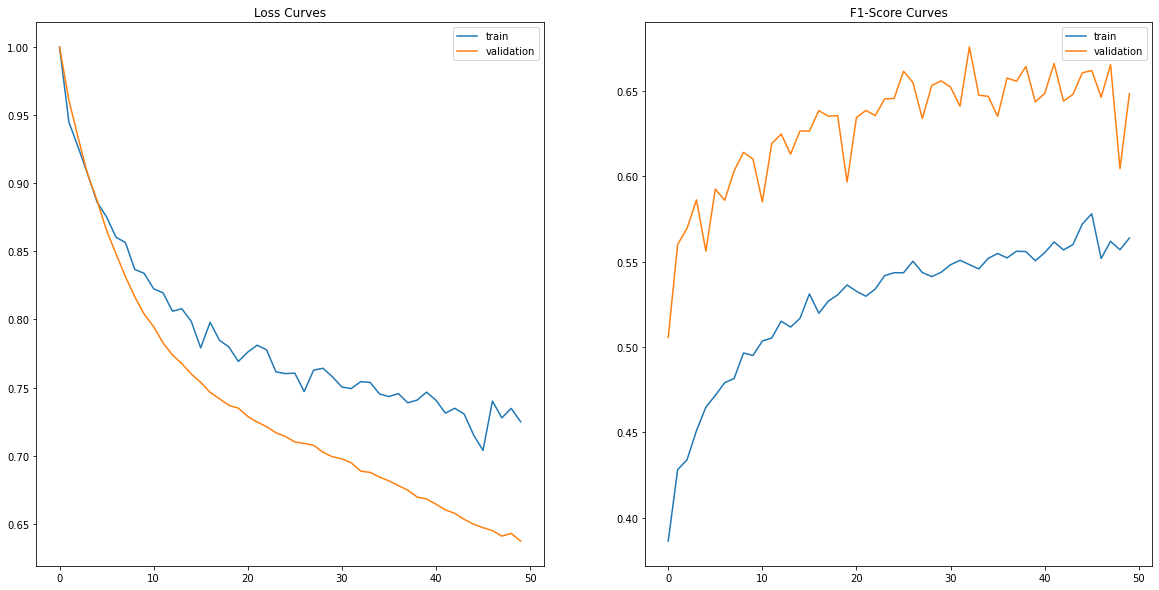

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

history_ = history.history
loss = history_.get('loss')
f1 = history_.get('macro_f1')
val_loss = history_.get('val_loss')
val_f1 = history_.get('val_macro_f1')

ax[0].set_title("Loss Curves")
ax[0].plot(loss/np.max(loss), label="train")
ax[0].plot(val_loss/np.max(val_loss), label="validation")
ax[0].legend()

ax[1].set_title("F1-Score Curves")
ax[1].plot(f1, label="train")
ax[1].plot(val_f1, label="validation")
ax[1].legend()

## Testing the model

### Predicting on the test dataset

In [33]:
unbatched_test = test_dataset.unbatch()
y_true = []
texts = []
feats = []
for x, y in tq.tqdm(unbatched_test.as_numpy_iterator(), total=TEST_SIZE):
    y_true.append(y)
    texts.append(x['text_model_input'])
    feats.append(x['cnn_model_input'])

In [34]:
texts = tf.convert_to_tensor(texts)
feats = tf.convert_to_tensor(feats)
y_true = np.array(y_true)
y_pred = model.predict([texts, feats])
y_classes = np.where(y_pred > 0.5, 1, 0)
del texts
del feats

### Evaluating on the train dataset

In [30]:
model.evaluate(train_dataset)

188/188 [==============================] - 9s 30ms/step - loss: 9.1475 - macro_f1: 0.6057


[9.147467613220215, 0.6057491302490234]

### Evaluating on the test dataset

In [31]:
model.evaluate(test_dataset)

47/47 [==============================] - 5s 33ms/step - loss: 9.0768 - macro_f1: 0.6754


[9.076810836791992, 0.6753981113433838]

### Evaluating on the complete dataset

In [32]:
model.evaluate(train_dataset.concatenate(test_dataset))

235/235 [==============================] - 14s 30ms/step - loss: 9.1360 - macro_f1: 0.6170


[9.13603401184082, 0.6170454025268555]

In [35]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

metric = tfa.metrics.HammingLoss(mode="multilabel", threshold=0.5)
metric.update_state(y_true, y_pred)
print("Hamming Loss: {}".format(metric.result().numpy()))
print("Hamming Score: {}".format(hamming_score(y_true, y_classes)))

Hamming Loss: 0.05403333529829979
Hamming Score: 0.6470999999999999


### Show predictions from the test dataset

Actual: ['person' 'dining table']
Predicted: ['person' 'dining table']


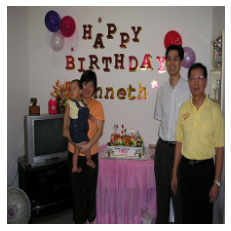

In [56]:
index = np.random.randint(0, TEST_SIZE)
for (feats, labs) in unbatched_test.skip(index).take(1):
    text = feats['text_model_input']
    image = feats['cnn_model_input']
    image_show = feats['original_images']

image = preprocess_image(image_show)
pred_img = model.predict([tf.convert_to_tensor([text]), np.expand_dims(image, axis=0)])
class_img = np.where(pred_img > 0.5, 1, 0)
print("Actual: {}".format(labels[labs.numpy() == 1]))
plt.imshow(np.clip(image_show/255., 0, 1))
plt.axis('off')
print("Predicted: {}".format(labels[class_img[0] == 1]))

### Classification Report

In [57]:
complete_dataset = train_dataset.concatenate(test_dataset).unbatch()

In [58]:
y_true_complete = []
texts = []
feats = []
for x, y in tq.tqdm(complete_dataset.as_numpy_iterator(), total=DATASET_SIZE):
    y_true_complete.append(y)
    texts.append(x['text_model_input'])
    feats.append(x['cnn_model_input'])
texts = tf.convert_to_tensor(texts)
feats = tf.convert_to_tensor(feats)
y_pred_complete = model.predict([texts, feats])
y_classes_complete = np.where(y_pred_complete > 0.5, 1, 0)
del texts
del feats

#### Complete dataset

In [59]:
print(classification_report(y_true_complete, y_classes_complete, zero_division=1))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      5482
           1       0.95      0.71      0.81       533
           2       0.98      0.69      0.81       652
           3       0.91      0.90      0.90       280
           4       0.69      0.71      0.70      1035
           5       1.00      0.88      0.94       309
           6       0.98      0.92      0.95       282
           7       0.96      0.84      0.90       548
           8       0.84      0.92      0.88       313
           9       1.00      0.89      0.94       290
          10       0.84      0.92      0.88       315
          11       0.73      0.75      0.74       657
          12       0.99      0.90      0.94       547
          13       0.97      0.87      0.92       318
          14       0.87      0.85      0.86       338
          15       0.69      0.66      0.67       621
          16       0.70      0.83      0.76      1221
          17       0.95    

#### Test dataset

In [60]:
print(classification_report(y_true, y_classes, zero_division=1))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       932
           1       0.90      0.66      0.76       136
           2       0.98      0.86      0.91       106
           3       0.81      0.84      0.82        85
           4       0.61      0.61      0.61       132
           5       1.00      0.78      0.87        89
           6       0.93      0.83      0.88        84
           7       0.92      0.77      0.84        71
           8       0.87      0.76      0.81        96
           9       1.00      0.77      0.87       104
          10       0.76      0.88      0.82        86
          11       0.65      0.72      0.68       186
          12       0.96      0.81      0.88       140
          13       0.98      0.90      0.94        92
          14       0.50      0.77      0.61        48
          15       0.58      0.51      0.54       194
          16       0.62      0.75      0.68       271
          17       0.87    